In [1]:
from mongoengine import *
import numpy as np
import datetime 
import pandas
import matplotlib.pyplot as plt
import sklearn
import tabulate


print(pandas.__version__)
print(sklearn.__version__)
print(np.__version__)

1.2.1
0.24.1
1.20.1


In [2]:
connect("GDP-test", host = "localhost", port = 27017)
class Detection(Document):
    id_webcam = IntField(required=True)
    city = StringField(required=True)
    location = StringField(required=True)
    latitude = FloatField(required=True)
    longitude = FloatField(required=True)
    numPeople = IntField(required=True)
    date = DateTimeField(required=True)
    time = DateTimeField(required=True)
    type = IntField(required=True)
    weather_description = StringField()
    temperature = FloatField()
    day_of_week = IntField()

In [3]:
# print(Detection.objects.distinct('city')) # vedere se posso prendere solo le città per poi fare query distinte
table = pandas.DataFrame(Detection.objects(city='Djakovo',type=0).as_pymongo()) #prelevo i dati di roma

table = table.dropna()

most_freq = lambda x: x.value_counts(dropna=True).index[0]

table_a = table
table_a = table_a.drop(columns = ['_id','id_webcam','city','type','date','location','latitude','longitude'])
table_a['time'] = pandas.to_datetime(table_a['time'])
table_a.sort_values(by='time', inplace=True)
#print(table_a.columns)
#table_1 = table_a.resample('30T', on='time').agg({'numPeople': 'mean', 'temperature' : 'mean', 'weather_description'}).head(20)
tb = table_a.groupby([pandas.Grouper(key='time', freq='30T')], as_index=False).agg( time=('time', most_freq)
                                                                   , meanPeople=('numPeople', 'mean')
                                                                   , temp=('temperature','mean')
                                                                   , weather=('weather_description', most_freq )
                                                                   , day_of_week=('day_of_week', most_freq))


tb = tb.dropna()

# tb.plot('time','meanPeople')
#tb['hour'] = tb['time'].apply(tb['time'].hour)
# #print(type tb['time'])
#print(tb.to_markdown())
#print(table_a.to_markdown())
# tb.plot('time','numPeople')

<AxesSubplot:xlabel='time'>

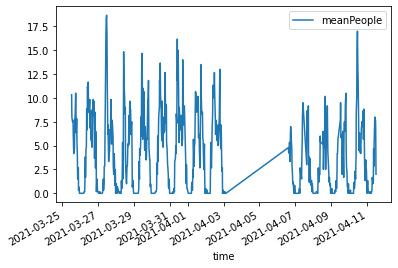

In [4]:
#print(tb.columns)
tb.plot('time','meanPeople')
# fc_table.plot('time')

In [5]:
import sklearn.preprocessing

class weather_forecast(Document):
    latitude = FloatField(required=True)
    longitude = FloatField(required=True)
    datetime = DateTimeField(required=True)
    weather_description = StringField()
    temperature = FloatField()
    

    
forecast = pandas.DataFrame(weather_forecast.objects(latitude='45.309812').as_pymongo()) #prelevo i dati di Djakovo
forecast = forecast.drop(columns = ['_id','latitude','longitude'])

forecast['datetime'] = pandas.to_datetime(forecast['datetime'])
forecast = forecast.groupby('datetime').first().reset_index()
forecast.sort_values(by='datetime', inplace=True)


today = datetime.datetime.today()
tomorrow = today + datetime.timedelta(days=1)
midnight0 = datetime.datetime.combine(today, datetime.datetime.min.time())
midnight1 = datetime.datetime.combine(tomorrow, datetime.datetime.min.time())

forecast = forecast.loc[(forecast['datetime'] >= midnight0)]
forecast = forecast.loc[(forecast['datetime'] < midnight1)].reset_index()
# print(forecast.to_markdown())


weekday = np.full((24,1),today.weekday())
fc = pandas.DataFrame()
fc.insert(0,'time', np.arange(0,24))
fc.insert(1,'temp', forecast['temperature'].iloc[0:24])
fc.insert(2,'weather', forecast['weather_description'].iloc[0:24])
fc.insert(3,'day_of_week', weekday[0:24])

forecast_dummies = fc['weather'].unique()
detection_dummies = tb['weather'].unique()
le = sklearn.preprocessing.LabelEncoder()
le.classes_ = np.unique(np.concatenate((forecast_dummies, detection_dummies), axis=0))

fc['weather'] = le.transform(fc['weather'])
tb['weather_dummy'] = le.transform(tb['weather'])

# print(le.classes_)
# le.fit(fc['weather'])
# le.fit(table_a['weather_description'])

# print(le.classes_)

# print(fc.columns)

# for index, row in forecast.iterrows():
#     print(index)
#     fc.insert(index,'aa', index)

print(fc)
# print(tb)

# data = {'time':  [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
#         'temp':  [5,4,3,3,3,3,4,7,8,10,13,14,11,16,14,12,12,12,11,10,9,8,6,6],
#         'day_of_week': [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6],
#         'weather':     [0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1]
#         }

# df = pandas.DataFrame (data, columns = ['time','temp','day_of_week','weather'])

    time   temp  weather  day_of_week
0      0   8.85        1            6
1      1   8.64        2            6
2      2   8.39        2            6
3      3   8.05        0            6
4      4   7.39        0            6
5      5   6.41        0            6
6      6   5.99        0            6
7      7   6.64        7            6
8      8   9.05        7            6
9      9  11.10        0            6
10    10  12.23        6            6
11    11  13.65        6            6
12    12  14.15        6            6
13    13  14.39        6            6
14    14  11.31        3            6
15    15  11.21        6            6
16    16  11.87        6            6
17    17  13.74        6            6
18    18  13.05        6            6
19    19  11.27        6            6
20    20  10.83        6            6
21    21  10.11        6            6
22    22   9.63        6            6
23    23   8.80        0            6


In [6]:
# s1 = datetime.datetime(2021,3,26)
# e1 = datetime.datetime(2021,3,27)
# q1 = {'date': {'$gte': start, '$lt': end}, 'city' : 'Roma'}
# t1 = pandas.DataFrame(Detection.objects(__raw__=q1).as_pymongo())


# table = table.drop(columns = ['_id','id_webcam','city','date','type','location','latitude','longitude'])
# table.plot('time','numPeople')

In [7]:
tb['time'] = tb['time'].dt.hour
#tb['time'] = (tb['time'].dt.hour).astype(int)#modifico le colonne con i valori che mi servono

In [8]:
import sklearn.model_selection

# tb['weather'] = pandas.get_dummies(tb['weather']) #il weather viene convertito con parametri interi

# print(tb.to_markdown())
tb = tb.dropna()
tb = tb.reset_index()

#divide the dataframe 70-30 for train and test
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    tb[['time','temp','day_of_week','weather_dummy']], 
    tb['meanPeople'], 
    test_size = 0.33, shuffle = True, random_state= 42)

In [9]:
#Modello tipo Regressione Lineare standard
import sklearn.linear_model

modelLReg = sklearn.linear_model.LinearRegression()
#provo a dargli in pasto tutto
#prima di questo ora bisogna dividere tutto il dataset in 70-30
# print(x_train.to_markdown())
modelLReg.fit(x_train, y_train)


# The coefficients
print('Coefficients: \n', modelLReg.coef_)

# The mean square error
print("Residual sum of squares: %.2f" % np.mean((modelLReg.predict(x_test) - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % modelLReg.score(x_test, y_test))



Coefficients: 
 [ 0.07690203  0.36899351 -0.18659438 -0.04644032]
Residual sum of squares: 10.04
Variance score: 0.36


In [10]:
# data = {'time':  [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
#         'temp':  [5,4,3,3,3,3,4,7,8,10,13,14,11,16,14,12,12,12,11,10,9,8,6,6],
#         'day_of_week': [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6],
#         'weather':     [0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1]
#         }

# df = pandas.DataFrame (data, columns = ['time','temp','day_of_week','weather'])

#print(model.predict(df))
# plt.title("Lin Reg")
# plt.plot(df['time'],modelLReg.predict(df))

In [11]:
#Modello tipo Lasso
# modelLasso = sklearn.linear_model.Lasso()

# modelLasso.fit(x_train,y_train)
# print('Lasso score : %.2f' % modelLasso.score(x_test,y_test))
# plt.title("Lasso")
# plt.plot(df['time'],modelLasso.predict(df))

In [12]:
#Modello tipo Ridge
# modelRidge = sklearn.linear_model.Ridge()

# modelRidge.fit(x_train,y_train)
# print('Ridge score : %.2f' % modelRidge.score(x_test,y_test))
# plt.title("Ridge")
# plt.plot(df['time'],modelRidge.predict(df))

Forest score : 0.78
[ 0.  0.  0.  0.  0.  0.  2.  1.  1.  7. 11.  8.  4.  4.  6.  6.  5.  8.
  8.  8.  6.  5.  1.  1.]


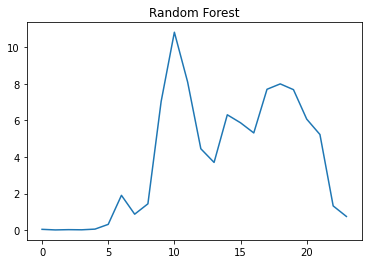

In [13]:
#Modello tipo Forest
from sklearn.ensemble import RandomForestRegressor

modelForest = RandomForestRegressor(n_estimators = 1000)

modelForest.fit(x_train,y_train)
print('Forest score : %.2f' % modelForest.score(x_test,y_test))
forest_prediction= modelForest.predict(fc)
plt.title("Random Forest")
forest_prediction = np.rint(forest_prediction)
#ATTENZIONE: CONVERTENDO IN INTERO PERDO LA PRECISIONE.
print(forest_prediction)
plt.plot(fc['time'],modelForest.predict(fc))

In [22]:
#table = table.drop(columns = ['_id','id_webcam','city','date','type','location','latitude','longitude']) #tolgo colonne inutili
#table.plot('time','numPeople')
#table['time'] = table['time'].dt.strftime('%H').astype(int)#modifico le colonne con i valori che mi servono
#table['weather_description'] = pandas.get_dummies(table['weather_description']) #il weather viene convertito con parametri interi
#print(table.to_markdown())

#start = datetime.datetime(2021,3,26)
#end = datetime.datetime(2021,3,27)
#raw_query = {'date': {'$gte': start, '$lt': end}, 'city' : 'Roma'}
#table = pandas.DataFrame(Detection.objects(__raw__=raw_query).as_pymongo())
#table = table.drop(columns = ['_id','id_webcam','city','date','type','location','latitude','longitude'])
#table.plot('time','numPeople')

#divide the dataframe 70-30 for train and test
#x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
#    table[['time','temperature','day_of_week','weather_description']], 
#    table['numPeople'], 
#    test_size = 0.33, shuffle = True, random_state= 42)

timePred = datetime.datetime.today().replace(hour=0, minute=0, second=0, microsecond=0) + datetime.timedelta(days = 1)
timeDelta = datetime.timedelta(hours = 1)
xTime = []
xtime = np.asarray(xTime)
for i in range(24):
    xTime.append(timePred+timeDelta*i)
dtPrediction = pandas.DataFrame()
dtPrediction.insert(0,'id_webcam', table['id_webcam'].iloc[0:24])
dtPrediction.insert(1,'city', table['city'].iloc[0:24])
dtPrediction.insert(2,'location', table['location'].iloc[0:24])
dtPrediction.insert(3,'latitude', table['latitude'].iloc[0:24])
dtPrediction.insert(4,'longitude', table['longitude'].iloc[0:24])
dtPrediction.insert(5,'numPeople', forest_prediction[0:24])
dtPrediction.insert(6,'date', forecast['datetime'].iloc[0:24])
dtPrediction.insert(7,'time',  forecast['datetime'].iloc[0:24])
dtPrediction.insert(8,'type', int(1))
dtPrediction.insert(9,'weather_description', forecast['weather_description'])
dtPrediction.insert(10,'temperature', forecast['temperature'])
dtPrediction.insert(11,'day_of_week', fc['day_of_week'])

print(dtPrediction)
for i in range(24):
    Detection(id_webcam = dtPrediction['id_webcam'][i], city = dtPrediction['city'][i],location = dtPrediction['location'][i],latitude = dtPrediction['latitude'][i],longitude = dtPrediction['longitude'][i],numPeople = dtPrediction['numPeople'][i],date = dtPrediction['date'][i],time = dtPrediction['time'][i],type = dtPrediction['type'][i],weather_description = dtPrediction['weather_description'][i],temperature = dtPrediction['temperature'][i],day_of_week = dtPrediction['day_of_week'][i]).save()


    id_webcam     city      location   latitude  longitude  numPeople  \
0           3  Djakovo  DjakovoKorzo  45.309812  18.410428        0.0   
1           3  Djakovo  DjakovoKorzo  45.309812  18.410428        0.0   
2           3  Djakovo  DjakovoKorzo  45.309812  18.410428        0.0   
3           3  Djakovo  DjakovoKorzo  45.309812  18.410428        0.0   
4           3  Djakovo  DjakovoKorzo  45.309812  18.410428        0.0   
5           3  Djakovo  DjakovoKorzo  45.309812  18.410428        0.0   
6           3  Djakovo  DjakovoKorzo  45.309812  18.410428        2.0   
7           3  Djakovo  DjakovoKorzo  45.309812  18.410428        1.0   
8           3  Djakovo  DjakovoKorzo  45.309812  18.410428        1.0   
9           3  Djakovo  DjakovoKorzo  45.309812  18.410428        7.0   
10          3  Djakovo  DjakovoKorzo  45.309812  18.410428       11.0   
11          3  Djakovo  DjakovoKorzo  45.309812  18.410428        8.0   
12          3  Djakovo  DjakovoKorzo  45.309812  18

In [15]:
# columns = ['id_webcam','city','location',
#                                            'latitude','longitude','numPeople',
#                                            'date','time','type','weather_description',
#                                            'temperature','day_of_week']
# model = sklearn.linear_model.LinearRegression()
# #provo a dargli in pasto tutto
# #prima di questo ora bisogna dividere tutto il dataset in 70-30
# model.fit(x_train, y_train)


# # The coefficients
# print('Coefficients: \n', model.coef_)

# # The mean square error
# print("Residual sum of squares: %.2f" % np.mean((model.predict(x_test) - y_test) ** 2))

# # Explained variance score: 1 is perfect prediction
# print('Variance score: %.2f' % model.score(x_test, y_test))

# plt.plot(x_test['time'],y_test)


In [16]:

#robe vecchie sbagliate non guardare

# time, temperature, weather, numP = table['time'].dt.strftime('%H').astype(int),table['temperature'],table['weather_description'],table['numPeople']
# time = np.asarray(time)
# temperature = np.asarray(temperature)
# weather = np.asarray(weather)
# numP = np.asarray(numP)
# weatherDict = {'clear sky':0}

In [17]:
# for i in range(weather.size):
#     weather[i] = weatherDict[weather[i]]

In [18]:
# temperature = temperature.reshape(-1,1)
# time = time.reshape(-1,1)
# weather = weather.reshape(-1,1)
# timeTemp = np.concatenate((time,temperature,weather),axis = 1)
# print(timeTemp)
# model = sklearn.linear_model.LinearRegression()
# model.fit(timeTemp,numP) 

In [19]:
# start = datetime.datetime(2021,3,24)
# end = datetime.datetime(2021,3,29)
# raw_query = {'date': {'$gte': start, '$lt': end}, 'city' : 'Roma'}
# table = pandas.DataFrame(Detection.objects(__raw__=raw_query).as_pymongo())
# table = table.drop(columns = ['_id','id_webcam','city','date','type','location','latitude','longitude'])